In [10]:
import spatialdm as sdm
import pandas as pd
import numpy as np
import anndata as ann
from sklearn import metrics
from matplotlib import pyplot as plt

methods = ["truth", "Tangram", "transImpute", "transImpSpa", "transImpCls", "transImpClsSpa", "spaGE", "stPlus"]
name_mapping = {"transImpute":"TransImp", "transImpSpa":"TransImpSpa", "transImpCls":"TransImpCls", "transImpClsSpa":"TransImpClsSpa"}
tmp_loc_path = "../../output/locations/#.csv"
tmp_counts_path = "../../output/#ext_singlecell_$.csv"

color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']

In [ ]:



def read_data(ST_name):
    loc = pd.read_csv(tmp_loc_path.replace("#", ST_name))
    adatas = {}
    for method in methods:
        map_name = name_mapping[method] if method in name_mapping else method
        adatas[map_name] = ann.read_csv(tmp_counts_path.replace("#", ST_name).replace("$", method))
        adatas[map_name] = adatas[map_name][:, ~(adatas[map_name].var_names == "")]
        adatas[map_name].obsm['spatial'] = loc.values
        if "truth" in adatas:
            adatas[map_name] = adatas[map_name][:, adatas['truth'].var_names].copy()
    return adatas

def spatialdm(adata, spec):
    sdm.weight_matrix(adata, l=1.2, cutoff=0.2, single_cell=False)
    # find overlapping LRs from CellChatDB
    sdm.extract_lr(adata, spec, min_cell=1)
    # global Moran selection
    sdm.spatialdm_global(adata, 1000, specified_ind=None, method='both', nproc=1)
    # select significant pairs
    sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)
    valid_genes = [True if l != r else False for l,r in zip(adata.uns['global_res'].Ligand0, adata.uns['global_res'].Receptor0)]
    print(len(valid_genes), adata.uns['global_res'].shape[0])
    sel = adata.uns['global_res'].index[valid_genes]
    adata.uns['global_res'] = adata.uns['global_res'].loc[sel]
    adata.uns['global_I'] = adata.uns['global_I'][valid_genes]
    adata.uns['global_res'].sort_values(by='fdr')
    
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in adatas:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] > 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + 1e-100)
        
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in adatas:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] > 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        score = adatas[md].uns['global_res'].loc[genes].global_I.values
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    
adata_dict = {}    
for ST_name, spec in zip(["melanoma", "mouseliver", "intest", "breastcancer"], ["human", "mouse", "human", "human"]):
    print(ST_name, spec)
    adatas = read_data(ST_name)
    for md in adatas:
        spatialdm(adatas[md], spec)
    adata_dict[f"{ST_name}_{spec}"] = adatas
    precision_recall_curve(adatas, ST_name)
    roc_curve(adatas, ST_name)
    print("#"*25)

    
    

In [ ]:
import pickle
with open("../../output/spatialdm.pkl", 'wb') as outfile:
    pickle.dump(adata_dict, outfile)

In [8]:
import pickle
with open("../../output/spatialdm.pkl", 'rb') as infile:
    adata_dict = pickle.load( infile)

melanoma_human


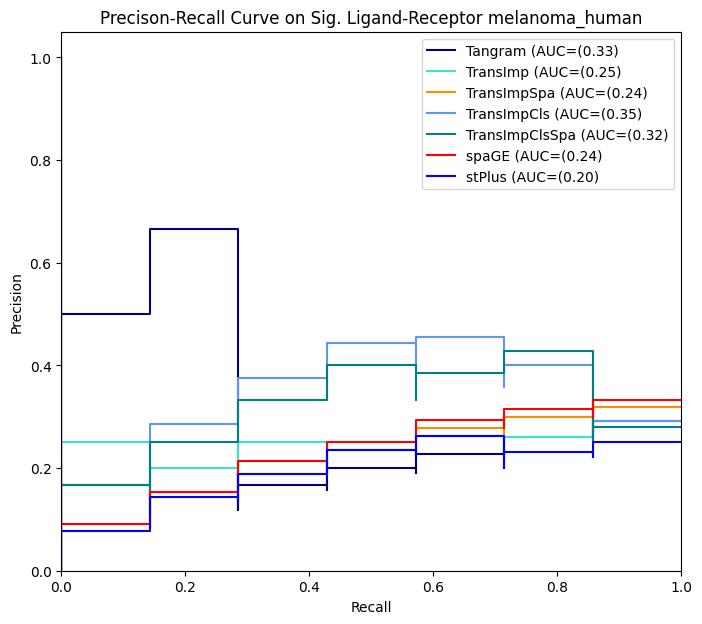

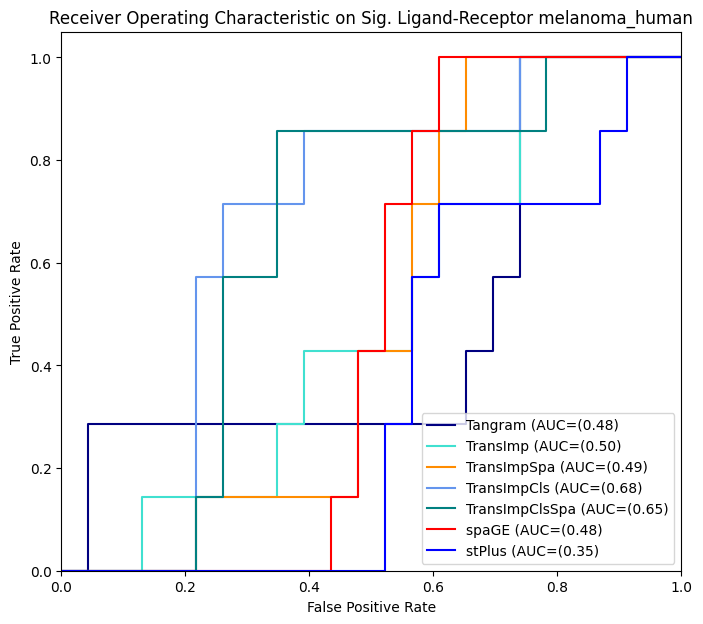

#########################
mouseliver_mouse
stPlus Fewer genes than truth: 169 vs 302


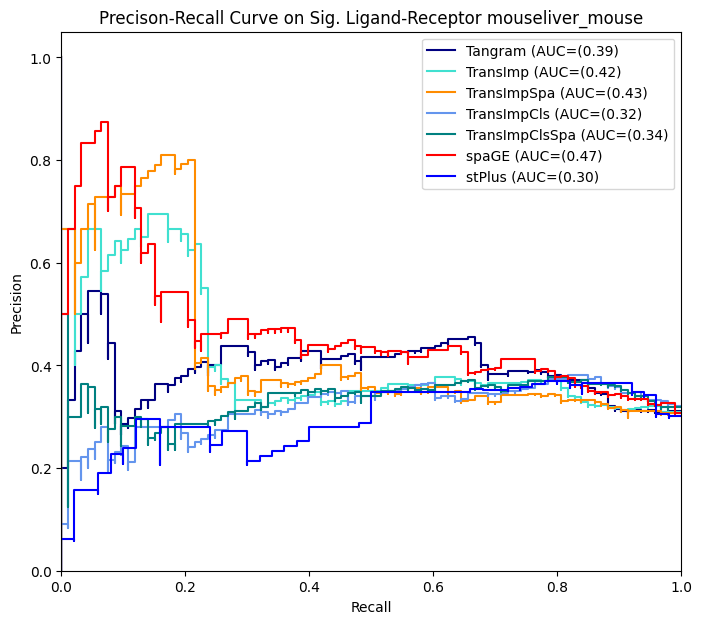

stPlus Fewer genes than truth: 169 vs 302


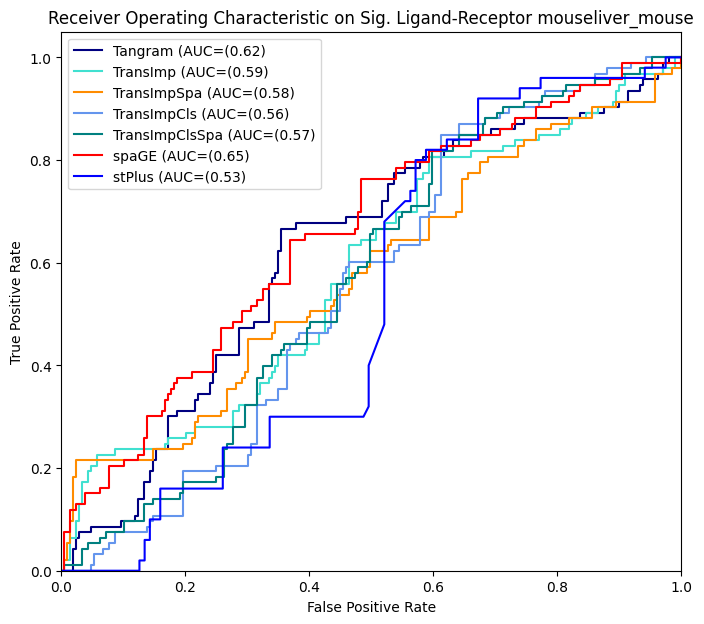

#########################
intest_human


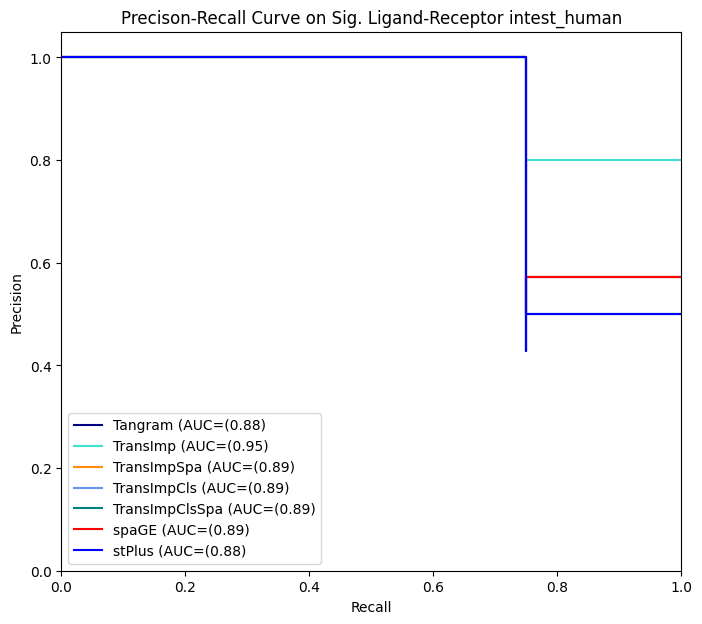

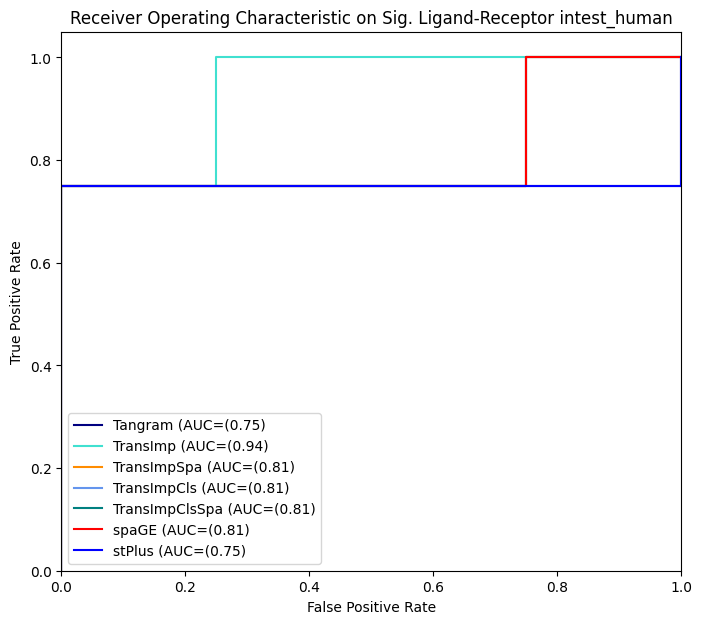

#########################
breastcancer_human


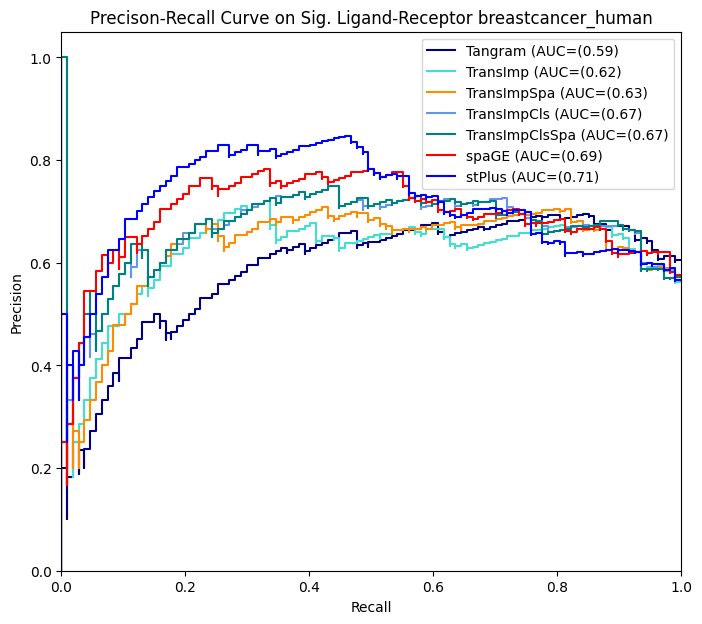

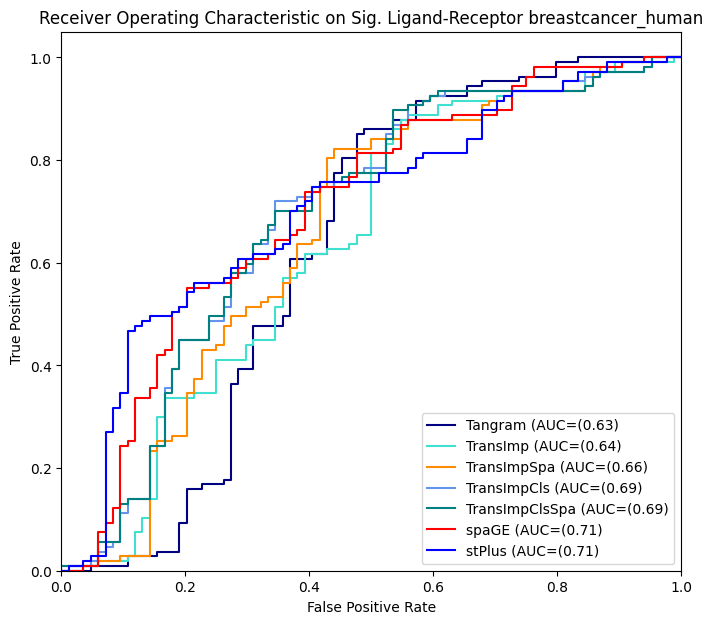

#########################


In [15]:
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in adatas:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] > 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + 1e-300)
        
        adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in adatas:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] > 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        
        # score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + 1e-300)
        adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    
  
for ST_name, adatas in adata_dict.items():
    print(ST_name)
    precision_recall_curve(adatas, ST_name)
    roc_curve(adatas, ST_name)
    print("#"*25)